# U.S. Health Care Anaylsis
#### Lexi Greenberg and Azzy Zeigler 

## Introduction

We decided to focus on the question: Does the cost and availability of healthcare affect the number of people who seek medical help? If so, where and by how much?  We want to see how people’s behaviors towards getting medical help vary over time and location in this country. It will be a story of how outside factors impact people’s personal health decisions. 

Our question is important because healthcare—specifically the US healthcare system—impacts people’s daily lives. As Engineers, especially Biomedical engineers, we should know how these systems affect those living in them. 

Our main first steps were looking at how availibility to healthcare is distributed amoung the states and how the cost has changed over time. 

**Note that our methodology and results sections will go back and forth between each other so you can see the process of how each of our graphs is made**

In [1]:
# importing all the libraries we need for the project 

import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
from bs4 import BeautifulSoup
import json  
import requests

## Methodology 
### Getting the data

We are getting our data from the U.S. inflation calculator, the world population review website, and teh Kaiser Family Foundation website. All of these are repuatal and used for safe polling and data gathering. The U.S. inflation calcultor contained a table of the inflation percentages each month from 1948 to 2022 of health care related costs. The world population review website contained a table of the nuymber of people enrolled in medciaid, CHIP, and other related data state by state for 2025 (before the week of submission it was from 2022). The KFF website contained multiple charts of the number of emergency room visits state by state (per 1000 population) and total in the country for 1999 to 2022. 

Since the data on the KFF website was stored in a javascript file, we used the Beautiful Soup ‘find_all’ function to isolate all of the scripts that had JS. We then isolated the script that had the data we needed by indexing it, then cleaned to just the part of the indexed string that had the information we needed. We then cleaned this by using the ‘replace’ function. The end goal was to get a list of tuples, with the first value being each state and the second being the total hospital ER visits per 1,000 population. 

With the cleaned data, we further isolated the 51 states (includes District of columbia) into a variable called ‘Manipulated_data_2022. We then made a list of lists with this manipulated data using a for-loop that included every state, but we still had more data than we needed since this website broke up the different types of hospitals into Government, for-profit, non-profit, and. While this information may be helpful if we were working on a different visualization, we only needed the ‘Totals’ from all of these. We then made a tuple list that took the first and last value of each of these sublists, which we could to make part of our needed visualizations (a bar graph, comparing this data to web scrape Medicaid/CHIP data) 

Finally because we could not plot a list of tuples we created the file state_ER_visits.csv used a for loop to wrote into it each tuple as a row in a table to create a file that held a table of states with the correspoding number of hospital visits for that state. 

In [18]:
url = str(f"https://www.kff.org/other/state-indicator/emergency-room-visits-by-ownership/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D")

response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

script_tag = soup.find_all("script", type="text/javascript")

needed_tag = str(script_tag[24].contents)[694:-1321] #getting just the data we need, not the js stuff

needed_tag = needed_tag.replace("],[","]**[")

needed_tag = needed_tag.replace("]]]","]")

manipulated_data = needed_tag.split('**')

manipulated_data_2022 = manipulated_data[0:51]

newlist = []

for sublist in manipulated_data_2022:
    str_to_list = json.loads(sublist)
    newlist.append(str_to_list)

tuplelist = []

for sublist in newlist:
    tuplelist.append([sublist[0],int(sublist[-1])])

with open("state_ER_visits.csv", "w") as file:
    file.write("States,Number of ER Visits" + "\n")
    for tup in tuplelist:
            tup[1] = str(tup[1])
            string_tup = ",".join(tup)
            file.write(string_tup + "\n")

We tried originally to iterate through each sub webpage of different charts to get the number of total U.S emergency room visits for different years, but we found that was not possible with how the data was stored (it was static, so even though the numbers on the website updated, the numbers that the web scraping was getting remained the same). Because of this: we compiled all of the years and us totals into a CSV file (US-ER-Totals.csv) to look at and use manually, but still use Beautiful Soup to get the data for each state in 2022 as shown above. 

We then used pandas to read the csv files into DataFrames so we can later process and clean the data in order to graph it.

We got our inflation data through web scraping with a pandas read_html command, which isolated the table in the website link to the U.S. inflation calculator and saved the information from that table into a dataframe. We did the same process for our medicaid enrollment by state data from the world population website. 

In [3]:

# removes futurewarnings from showing up due to errors='ignore'
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
# downloading the librairies we use 

total_ER_visits_US = pd.read_csv("US-ER-Totals.csv")

state_ER_visits = pd.read_csv("state_ER_visits.csv")

medicaid_data = pd.read_html("https://worldpopulationreview.com/state-rankings/medicaid-enrollment-by-state")[0]
# importing in data about the number of people per state enrolled in medicaid in 2025 as a dataframe

health_care_inflation_data = pd.read_html("https://www.usinflationcalculator.com/inflation/health-care-inflation-in-the-united-states/")[0]
# importing in data that shows the inflation percentage of health care costs in the US from 1948 to 2022 as a dataframe                   


We currently have a dataframe that holds all the inflation percentages for the US economy for 1948 to 2022 by month, which we have manipulated by taking the average across months for each year to define one average inflation percentage for each year. When we first accessed the data, all the percentages were saved as strings so we converted every entity into floats so we  could perform mathematical equations with the data in the frame. 

To turn these percentages into actually prices and costs we used our homemade function find_health_care_costs, which takes a dataframe of inflation percentages and the cost of health care for one year and cycles through the length of the dataframe, multiplying the inflation rate by the current price to get the price point for the following year, saving each run in a list.

In [4]:

health_care_inflation_data = health_care_inflation_data.apply(pd.to_numeric, axis=1, downcast='float', errors = 'ignore')
# turning the health care inflation data entries from strings to floats so mathmatical equations can be used on the data

In [5]:

def find_health_care_costs(starting_cost, yearly_inflation: pd.DataFrame):
    """
    Takes the cost of healthcare for a previous year and multiplies it by 
    the inflation rate of the next year to find that next year's health care costs

    Args:
        starting_cost: a float type that represents the cost of health care in
            the first year of the range of time
        yearly_inflation: a list of float types in a DataFrame that represent the
            inflation percentage of between the last year and the next that is applied 
            to the cost of health acre from previous years to generate next year's costs

    Returns:
        Returns a list of floats and/or integers that represent the cost of healthcare 
            for a range of years
    """
    health_care_costs = []
    
    for item in yearly_inflation:
        percent = 1 + (item/100)
        single_year_cost = (percent * starting_cost)
        single_year_cost = round(single_year_cost)
        health_care_costs.append(single_year_cost)
        starting_cost = single_year_cost

    return health_care_costs


### Cleaning the Data
#### health_care_inflation_data

In [6]:
# this series takes the inflation perctanghe for each month in a row representing a year and finds the mean for that year, 
# saving the means in their own column to corresponde each mean as the inflation percnatge for that year 

display(health_care_inflation_data.head())


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1,1948.0,6.1,5.3,6.0,6.7,5.9,5.9,7.4,6.6,5.8,5.8,6.5,5.8
2,1949.0,5.7,5.7,5.0,3.5,3.5,3.5,2.1,2.8,2.8,2.1,1.4,1.4
3,1950.0,1.4,1.4,1.4,1.4,1.4,1.4,2.0,1.3,2.0,2.7,2.7,3.4
4,1951.0,3.3,3.3,4.7,4.7,5.3,5.3,4.6,5.3,4.6,4.6,5.2,5.8


While this table is very clear and helpful, it doesn't give us graphable information. This table originally holds the inflation percentage of healthcare focused costs for a single month of a year over many years. We will now process it to get a table of inflation percentages of that year by takeing the mean of each month across row. To find the mean we need to get rid of non numerical rows and columns, the ones that hold the years and months, so we remove them with the drop method. With those gone we can use the mean method along the rows to get the average inflation percentage of each year. 

In [7]:

years = health_care_inflation_data[0]
years.drop(years.index[-1], axis=0, inplace=True) # drops the last row which is empty 
years.drop(years.index[0], axis=0, inplace=True) # drops the first row which has not date, just a column title

inflation_percentage = health_care_inflation_data[1:78] # takes only the rows containing the inflation percentage to get rid of the row of month names

inflation_percentage.drop(inflation_percentage.columns[0], axis=1, inplace=True) # gets rid of the first column which contains all the years so we have only a DataFrame of inflation float values

health_care_inflation_mean = inflation_percentage.mean(axis=1) # takes the mean of each row to know the average inflation cost for each year

display(health_care_inflation_mean) # checking work


1         6.15
2     3.291667
3        1.875
4        4.725
5        5.475
        ...   
73    4.116667
74    1.233333
75        4.05
76    0.483333
77         2.7
Length: 77, dtype: object

Now we will use our custom helper function, find_health_care_costs to turn the percentages into actual cost amounts. Since we are starting at 1948 we looked up the average cost of a hopsital visit that year ($80.75) and inputted it into our function along with our table of year based inflation percentages. 

From our resulst we got a list of all the average costs of hospital visits by year in the U.S., which we turned into a DataFrame, then renamed the rows by year to keep better track of the corresponding prices. Finally, since we plan on graphing the data on hospital costs against our KFF data, we isolated the prices from 1999 to 2022, which alighs with KFF's range. 

In [8]:
# creating our first graph, the line graph

healthcare_cost_48to22 = find_health_care_costs(80.75, health_care_inflation_mean) # find our healthcare costs over time
healthcare_cost_48to22 = pd.DataFrame(healthcare_cost_48to22, columns=['Healthcare Costs That Year']) # store the final healthcare costs in a DataFrame

timeline_of_healthcare_cost = healthcare_cost_48to22.set_index(years) # make the name of the rows the years so we can call a cost from a certain year

healthcare_cost_99to22 = timeline_of_healthcare_cost[1999.0:2022.0] # isolating only the data from 1999 to 2022

display(healthcare_cost_99to22) # checking work


,Healthcare Costs That Year
0,
1999.0,1508
2000.0,1569
2001.0,1641
2002.0,1718
2003.0,1787
2004.0,1866
2005.0,1945
2006.0,2023
2007.0,2112


#### total_ER_visits_US

In [9]:
display(total_ER_visits_US.head())

,Year,USTotal
0,1999,365
1,2000,366
2,2001,372
3,2002,382
4,2003,382


To process the data surrounding total number of emergency room visits in the U.S. we simply renamed the axis for the rows to be the year and get rid of the Year column so we can plot this clearier later on. 

In [10]:

timeframe = total_ER_visits_US['Year']
total_ER_visits_US.drop(total_ER_visits_US.columns[0], axis=1, inplace=True) # getting rid of the 1st column that holds the years
total_ER_visits_US.set_index(timeframe, inplace=True) # renaming the rows by the year they correspond with
display(total_ER_visits_US.head()) # checking my work

,USTotal
Year,
1999,365
2000,366
2001,372
2002,382
2003,382


To plot our 1st graph we combined the two data sets we have processed and created (healthcare_cost_99to22 and total_ER_visits_US) using the concat function (this is why we named them by year, so their axises aligned so they can be combined). 

With these combined data sets in a table we plotted them both against time on a line graph.

,Cost of E.R Visit,USTotal
1999.0,1508,365
2000.0,1569,366
2001.0,1641,372
2002.0,1718,382
2003.0,1787,382


Text(0.5, 1.0, 'Cost of an E.R. visit vs the Number of E.R vists')

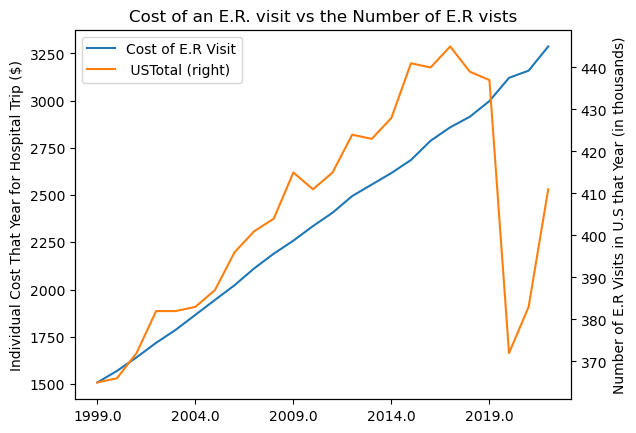

In [11]:
# combine the two dataframes into one so that they can be plotted simulationously 
combo_cost_visit_data = pd.concat([healthcare_cost_99to22, total_ER_visits_US], axis=1)
combo_cost_visit_data.rename(columns={'Healthcare Costs That Year': "Cost of E.R Visit"}, inplace=True)
combo_cost_visit_data.rename(columns={'USTotal': "Total E.R Visits"}, inplace=True)
display(combo_cost_visit_data.head())

# plot data 
combo_cost_visit_data.plot(secondary_y=combo_cost_visit_data.columns[1])
ax1, ax2 = plt.gcf().get_axes()
ax1.set_ylabel("Individual Cost That Year for Hospital Trip ($)")
ax2.set_ylabel("Number of E.R Visits in U.S that Year (in thousands)")
ax1.set_title("Cost of an E.R. visit vs the Number of E.R vists")


## Results
### Graph 1: Line Graph

As the cost of an hospital trip increases over time, so does the number of hospital visits. This could be due to the fact that populations increase over time and so there are just more people. It is unclear from our graph if there is a direct correlation, but they do both increase over time, yet the healthcare costs increased steadily over time at a constant linear pace. Meanwhile the number of emergency room visits fluctuates in a general growth pattern over time and then has a sudden dip in 2020, most likely due to the COVID-19 pandemic (people were out less and therefore getting injured less). Despite the number of visits decreasing, there was no effect on the rising health care costs. And post quarantine, when the healthcare costs were the highest they’ve ever been, the number of hospital visits began to increase at a higher rate then it was before the pandemic.

## Methodology
### medicaid_data

To make our next graph we need to create new data based on data we have in our medicaid_data varaible table

In [12]:
medicaid_data.head()


,Unnamed: 0,State,Medicaid Enrolled↓,CHIP Enrolled,Combined Enrolled,Medicaid Plus CHIP %,State Expanded
0,NaN,California,12668401,1290747,13959148,35.19%,Yes
1,NaN,New York,6789092,557900,7346992,36.74%,Yes
2,NaN,Texas,5374020,369745,5743765,18.03%,No
3,NaN,Florida,4752201,99598,4851799,20.35%,No
4,NaN,Illinois,3504288,245958,3750246,29.35%,Yes


First we remove the empty column Unnamed: 0. 

Next we rename a long data entry so it will fit better on a graph.

Then we reorganized the table so that the states were in alphebetical order to improve the spacing while graphing.

In [13]:

medicaid_data = medicaid_data.drop(columns=['Unnamed: 0'])
# get rid of the extra non important Unnamed: 0 column 

medicaid_data['State'] = medicaid_data['State'].replace('District of Columbia', 'D.C')
# rename Distrint of Columbia to D.C because others have said its easier to read that way

# medicaid_data_edit.loc[51, 'State Percentage Enrolled Out of Total US'] = other_state_perc
medicaid_data.sort_values(by='State', inplace=True)

Next we want to use the data in this column to find out what percentage of each state enrollment makes up of total enrollment, to do so we first need to sum the enrollment numbers for all the states to find the total enrolled in the whole country. 

To hold these new results we created a new column in the DataFrame that holds the number of people enrolled in each states divided by the totaled enrolled in the country called State Percentage Enrolled Out of Total US


In [14]:
total_US_pop_enrolled_MedicaidCm = medicaid_data['Combined Enrolled'].sum()
# find the total number of people enrolled in the country by summing each row entry

medicaid_data["State Percentage Enrolled Out of Total US"] = ((medicaid_data['Combined Enrolled']/total_US_pop_enrolled_MedicaidCm) * 100)
# finds the percentage each state makes up of the total US medicaid enrollment

medicaid_data.head()

,State,Medicaid Enrolled↓,CHIP Enrolled,Combined Enrolled,Medicaid Plus CHIP %,State Expanded,State Percentage Enrolled Out of Total US
29,Alabama,964161,197078,1161239,22.34%,No,1.265156
45,Alaska,251627,11902,263529,35.43%,Yes,0.287112
9,Arizona,2140101,143032,2283133,29.68%,Yes,2.487445
27,Arkansas,992158,37017,1029175,33.12%,Yes,1.121274
0,California,12668401,1290747,13959148,35.19%,Yes,15.208320


For us to best show how much each state contributes to teh total amount of people enrolled in medicaid and CHIP, we displayed our data as a pie graph, using the results from our newly created column. 

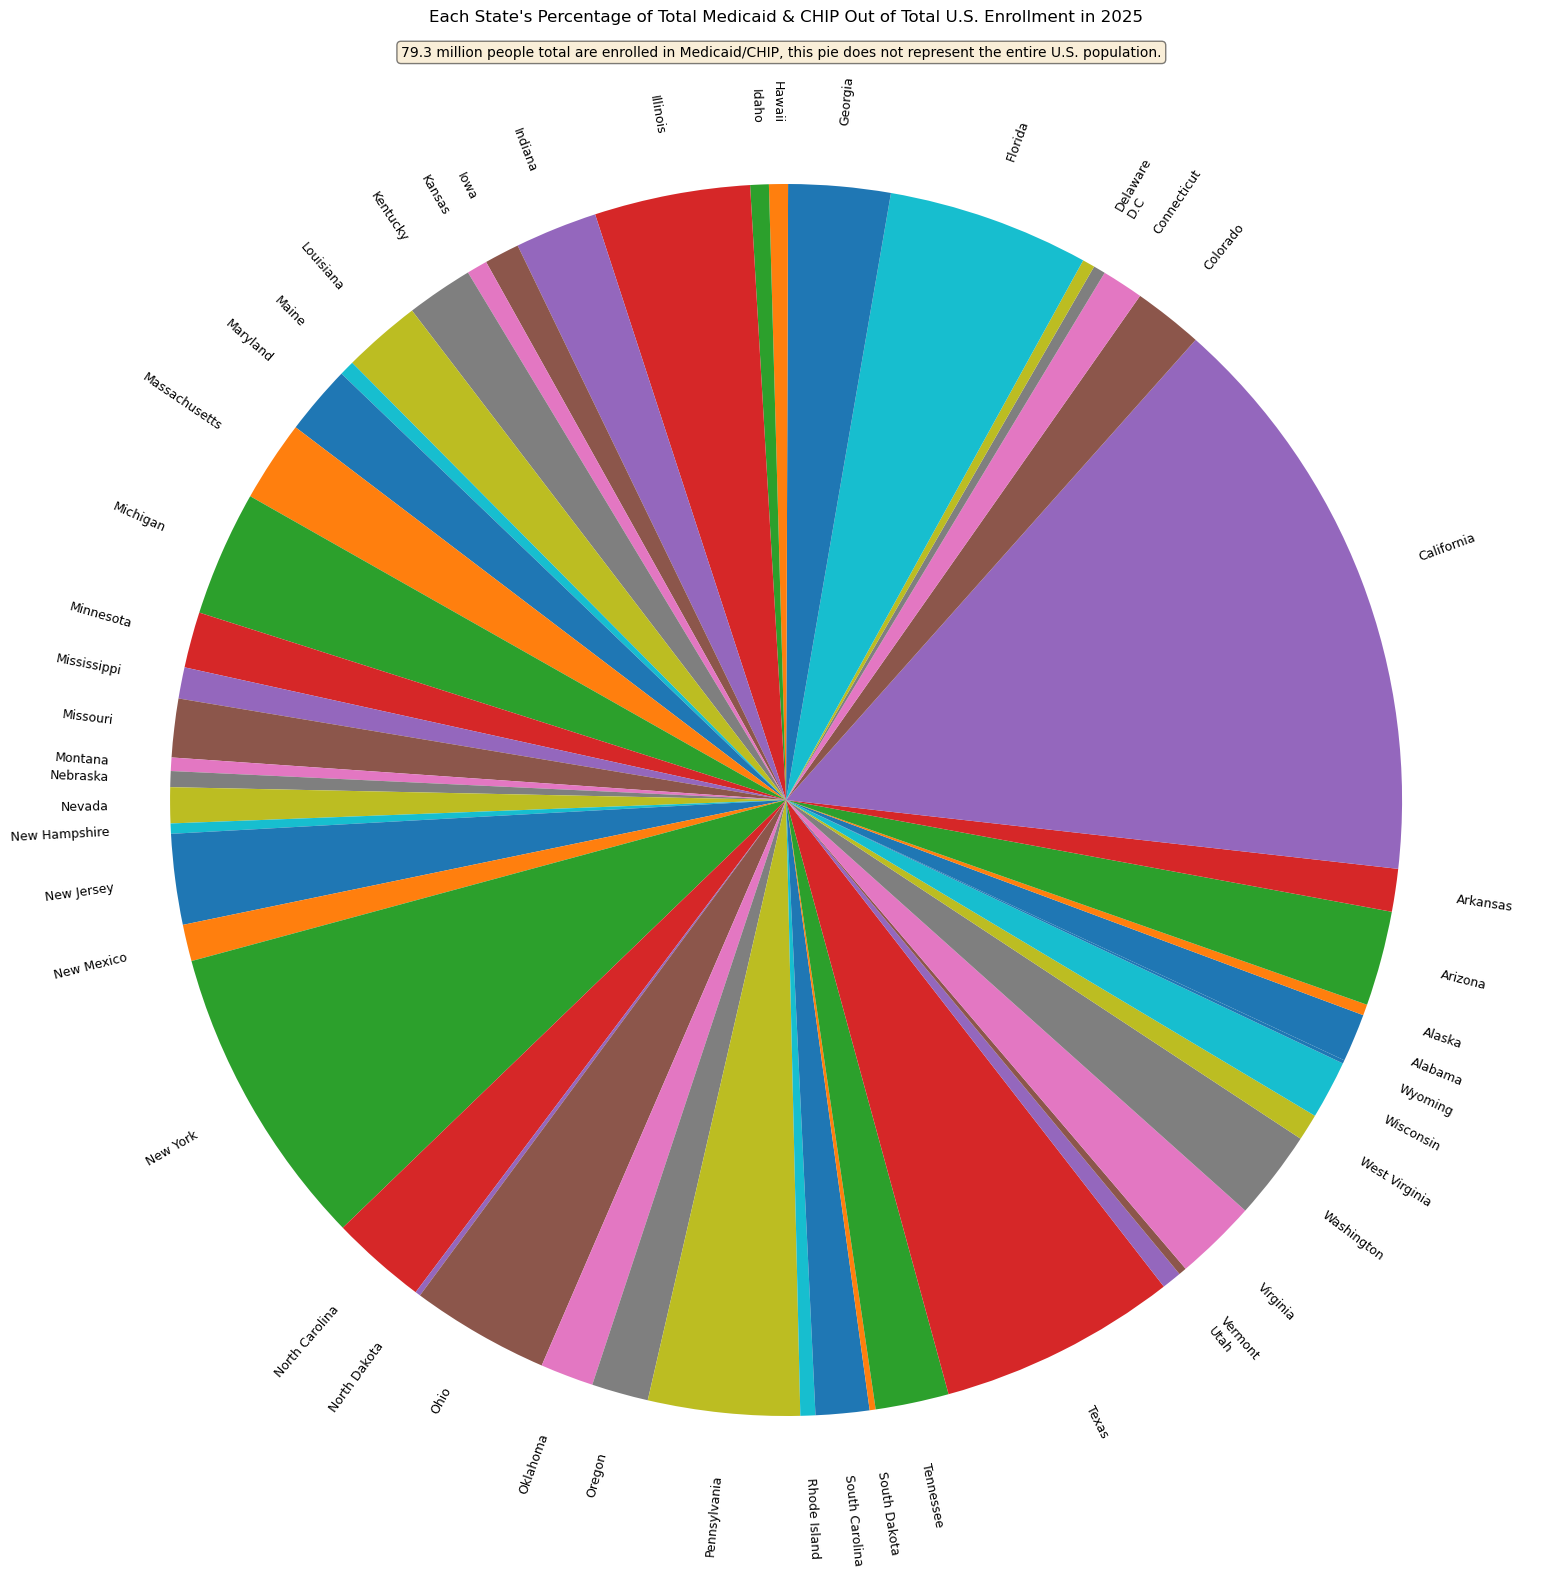

In [15]:
# plotting the pie graph

fig, ax = plt.subplots(figsize=(20,20))
l = ax.pie(medicaid_data["State Percentage Enrolled Out of Total US"], startangle=-25)

for label, t in zip(medicaid_data["State"], l[1]):
    x, y = t.get_position()
    angle = int(math.degrees(math.atan2(y, x)))
    ha = "left"

    if x<0:
        angle -= 180
        ha = "right"

    plt.annotate(label, xy=(x,y), rotation=angle, ha=ha, va="center", rotation_mode="anchor", size=9)
    
other_text = "79.3 million people total are enrolled in Medicaid/CHIP, this pie does not represent the entire U.S. population."

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.25, 0.99, other_text, transform=ax.transAxes, fontsize=10,
    verticalalignment='top', bbox=props)

ax.set_title("Each State's Percentage of Total Medicaid & CHIP Out of Total U.S. Enrollment in 2025")

plt.show()


## Results
### Graph 2: Pie Graph

From our pie graph we can see that states with higher populations contribute more to the total enrollment in Medicaid and Chip, which makes logical sense. Additionally it is true that larger urban areas have more medical crises, and the states that hold some of the biggest American cities take up the biggest portions of the pie. Overall this graph does not give us a lot of new information but does confirm lots of general assumptions about medical distribution throughout the different states, there is a direct correlation between state population size and how much of a percentage does the state take up of total people enrolled in Medicaid and C.H.I.P. 

## Methodology
### medcaid_data

Because medicaid_data hold so much information we use it for two of our graphs. For our final graph, we focused on the Medicaid Plus CHIP % column. Because we plan on graphing the results in that column we used a for loop to go through each item in the row, take away the % symbol, then turn the resulting numbers from a string into a float. We replaced the string column in the DataFrame with the float value column. 

In [16]:
# clean up data for bar graph
medicaid_and_CHIP_percentage = medicaid_data["Medicaid Plus CHIP %"] # isolate the column with the tptal enrollment for each state

# for loop turns all the % strings into float values so they can be plotted
for row in range(len(medicaid_and_CHIP_percentage)):
    percent_string = medicaid_and_CHIP_percentage[row]
    
    if type(percent_string) != str:
        continue

    else:
        percent_string = percent_string.replace('%', '')
        percent_float = float(percent_string)
        medicaid_and_CHIP_percentage[row] = percent_float

medicaid_data["Medicaid Plus CHIP %"] = medicaid_and_CHIP_percentage


We plot the percentage of a state's population enrolled in medicaid against the number of emergency room visits in their state in our final graph, using a doubled y axis bar graph. 

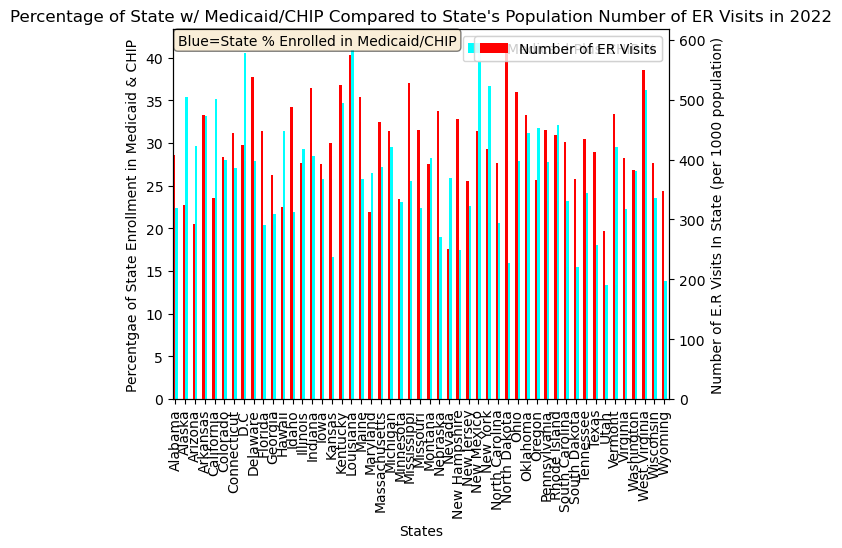

In [26]:
# plotting the bar graph

fig = plt.figure()

ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.25

ER_data = pd.DataFrame(state_ER_visits['Number of ER Visits'])  
ER_data.set_index(medicaid_data['State'], inplace=True) 


medicaid_and_CHIP_percentage_data = pd.DataFrame(medicaid_data["Medicaid Plus CHIP %"])
medicaid_and_CHIP_percentage_data.set_index(medicaid_data['State'], inplace=True)


ER_data.plot(kind='bar', color='red', ax=ax2, width=width, position=1) 
medicaid_and_CHIP_percentage_data.plot(kind='bar', color='cyan', ax=ax, width=width, position=0)

ax.set_xlabel('States')
ax.set_ylabel("Percentgae of State Enrollment in Medicaid & CHIP")
ax2.set_ylabel('Number of E.R Visits In State (per 1000 population)')
ax.set_title("Percentage of State w/ Medicaid/CHIP Compared to State's Population Number of ER Visits in 2022")

other_text = "Blue=State % Enrolled in Medicaid/CHIP"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.01, 0.99, other_text, transform=ax.transAxes, fontsize=10,
    verticalalignment='top', bbox=props)

plt.show()


## Results
### Graph 3: Bar Graph

 Please note that originally the website we are scrapping from the Medicaid Plus CHIP % was data from 2022, but the site updated this week to now represent the numbers for 2025. The site for the ER visits does not have 2025 data available, this graph is comparing data from separate years. Because the years of our data are different, it is hard to get any firm results. But it does appear that there is no correlation between the percentage of a state’s population enrolled in medicaid/CHIP and the number of ER visits in that state. Due to outside factors our results for this graph are inconclusive. Some interesting patterns do emerge, bigger states don’t necessarily have the highest ER visits nor the highest state enrollment, states with large urban centers have larger ER visits then rural states, and states with the highest populations don’t have the highest percentage of medicaid and CHIP enrollment. This goes against a lot of common assumptions about the medical field. 

## Conclusion 

The most important insights we learned from this project were that while prices for healthcare have increased, people have not seeked out less help because of it. People will continue to seek medical care in higher amounts over time (due to populations increasing) despite increasing prices. States with high Urban areas are where most people actively seek medical support through insurance, while the most rural areas have the least people enrolling in insurance. Midwestern states have the highest number of ER visits.  

Some ethical concerns we have surround the data sourcing is that we did not get permission from these sites to use their data. We copied it off of them without their knowledge so there are some ethical concerns there. Some of our websites also don’t state where their data is from so some of the hospitals tracked for their E.R. visits or individuals on Medicaid, don’t know their data is used in this project.

Some ethical implecations of our work is that though there is no name or identifying information we do have the number of people in each state who enrolled in government sponsored insurances such as Medicaid and CHIP and use their enrollment in the program for analysis for this project without them knowing. There are a lot of ethical concerns about using medical data for research because individuals usually are not asked if they want to be involved, even passively. And in this current political landscape it is incredibly dangerous to have your medical information public. 

The most difficult and challenging parts of this project were learning beautiful soup and it took up the largest part of our project. It was extremely frustrating because it had to learn from scratch and we are already beginners to python, it took a whole week to fully learn and understand all so we could get vital data for the project.

If we had more time on this project we would do a deeper search for data to make plots exploring different types of medical treatment seeked, the average premiums for different insurance companies, and even looking into disparities in seeking medical help between different identity groups. 

